In [ ]:
import os
import numpy as np
import pandas as pd
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import os

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation


Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 99% 308M/312M [00:03<00:00, 77.3MB/s]
100% 312M/312M [00:03<00:00, 97.2MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_segmentation')


In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_CHANNELS=3

In [ ]:
original_path='/content/brain_tumor_segmentation/images'
masks_path='/content/brain_tumor_segmentation/masks'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
dataset = BrainTumorDataset(image_dir=original_path, mask_dir=masks_path, transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
next(iter(train_loader))[1].size()

torch.Size([4, 1, 224, 224])

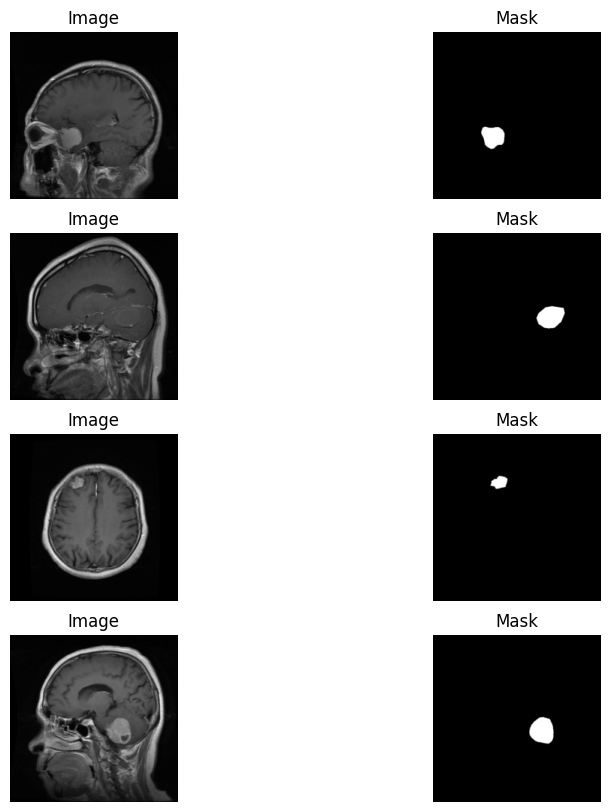

In [ ]:
import matplotlib.pyplot as plt

def show_images_masks(loader, num_examples=4):
    images, masks = next(iter(loader))

    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        # Image subplot
        plt.subplot(num_examples, 2, i * 2 + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
        plt.title("Image")
        plt.axis("off")

        # Mask subplot
        plt.subplot(num_examples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Remove the channel dimension and display in grayscale
        plt.title("Mask")
        plt.axis("off")

    plt.show()

show_images_masks(train_loader, num_examples=4)

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(UNet, self).__init__()

        # Encoding (Downsampling)
        self.encoder1 = self.conv_block(input_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoding (Upsampling)
        self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder6 = self.conv_block(1024, 512)

        self.upconv7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder7 = self.conv_block(512, 256)

        self.upconv8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder8 = self.conv_block(256, 128)

        self.upconv9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder9 = self.conv_block(128, 64)

        self.output = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        bottleneck = self.bottleneck(p4)

        # Decoding
        u6 = self.upconv6(bottleneck)
        u6 = torch.cat((u6, c4), dim=1)  # Concatenate
        c6 = self.decoder6(u6)

        u7 = self.upconv7(c6)
        u7 = torch.cat((u7, c3), dim=1)  # Concatenate
        c7 = self.decoder7(u7)

        u8 = self.upconv8(c7)
        u8 = torch.cat((u8, c2), dim=1)  # Concatenate
        c8 = self.decoder8(u8)

        u9 = self.upconv9(c8)
        u9 = torch.cat((u9, c1), dim=1)  # Concatenate
        c9 = self.decoder9(u9)

        outputs = self.output(c9)
        return outputs

In [ ]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    loss = 1 - loss.mean()
    return loss


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    train_loss = 0
    total_iou = 0
    num_batches = 0

    for images, masks in dataloader:


        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Calculate IoU
        iou = calculate_iou(outputs, masks)
        total_iou += iou
        num_batches += 1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        del images, masks, outputs, loss

    avg_train_loss = train_loss / len(dataloader)
    avg_iou = total_iou / num_batches  # Average IoU over all batches
    return avg_train_loss, avg_iou

In [ ]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    total_iou = 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            # Calculate IoU using the provided function
            iou = calculate_iou(outputs, masks)
            total_iou += iou

    avg_val_loss = val_loss / num_batches  # Average validation loss
    avg_val_iou = total_iou / num_batches  # Average IoU over all batches
    return avg_val_loss, avg_val_iou


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as improvement
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
        elif val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # Reset the counter if validation loss improves
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True

In [ ]:
def save_model(model, optimizer, epoch, best_val_loss, path="best_model.pth"):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_loss': best_val_loss
    }
    torch.save(state, path)
    print(f"Model saved with validation loss {best_val_loss}")

In [ ]:
def calculate_iou(outputs, masks):

    predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert probabilities to binary
    intersection = (predicted * masks).sum()  # Calculate intersection
    union = predicted.sum() + masks.sum() - intersection  # Calculate union

    iou = (intersection + 1e-6) / (union + 1e-6)  # Small epsilon added to avoid division by zero
    return iou.item()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5, save_path="best_model.pth"):
    early_stopping = EarlyStopping(patience=patience)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training step
        train_loss , train_iou = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Training Loss: {train_loss} IOU: {train_iou}")

        # Validation step
        val_loss , val_iou = validate_one_epoch(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss} IOU: {val_iou}")

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, optimizer, epoch, best_val_loss, path=save_path)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Stopped early at epoch", epoch+1)
            break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = UNet(input_channels=3, num_classes=1).to(device)

criterion = dice_loss
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=device, patience=10, save_path="best_brain_tumor_model.pth")

Epoch 1/50
Training Loss: 0.09035635755669331 IOU: 6.096840803433186e-05
Validation Loss: 0.06027148230993128 IOU: 3.415080273045905e-10
Model saved with validation loss 0.06027148230993128
Epoch 2/50
Training Loss: 0.058510441190242575 IOU: 0.02605179055529447
Validation Loss: 0.061658862397655265 IOU: 0.08872459957049568
EarlyStopping counter: 1/10
Epoch 3/50
Training Loss: 0.0546312360488012 IOU: 0.12514185361629582
Validation Loss: 0.06379210864278403 IOU: 0.22337762205136716
EarlyStopping counter: 2/10
Epoch 4/50
Training Loss: 0.04754942022324775 IOU: 0.22889090682306967
Validation Loss: 0.04448833440539318 IOU: 0.23790374270957376
Model saved with validation loss 0.04448833440539318
Epoch 5/50
Training Loss: 0.03964583667414491 IOU: 0.3284968181777446
Validation Loss: 0.03597941215742718 IOU: 0.4043176949762001
Model saved with validation loss 0.03597941215742718
Epoch 6/50
Training Loss: 0.03421590834868188 IOU: 0.38983653740517776
Validation Loss: 0.03912619807963054 IOU: 0.32

In [ ]:
# load best model

best_model = UNet(input_channels=3, num_classes=1).to(device)
checkpoint = torch.load("/content/drive/MyDrive/best_brain_tumor_model.pth")
best_model.load_state_dict(checkpoint['model_state_dict'])



<ipython-input-63-c2483a423eea>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/best_brain_tumor_model.pth")


<All keys matched successfully>

## Debug and Test


In [ ]:
images , masks = next(iter(val_loader))

print(images.size() , masks.size())


images.to(device)

# del images

torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0118, 0.0078,  ..., 0

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    images = images.to(device)  # Move images to the appropriate device
    outputs = best_model(images)  # Forward pass
    outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

outputs.size()

torch.Size([4, 1, 224, 224])

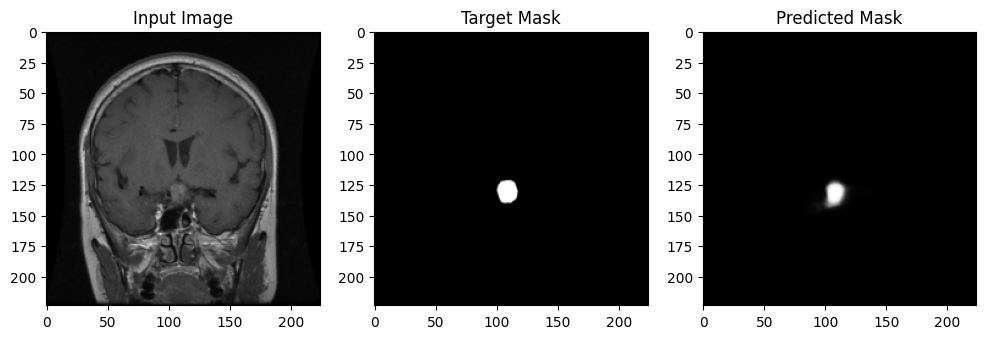

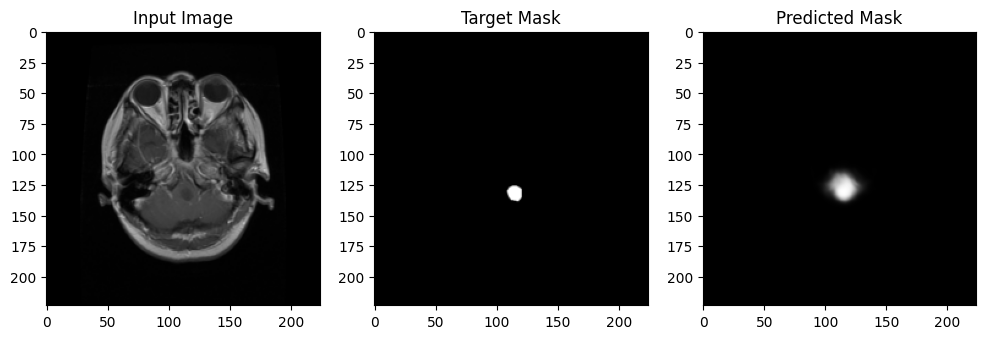

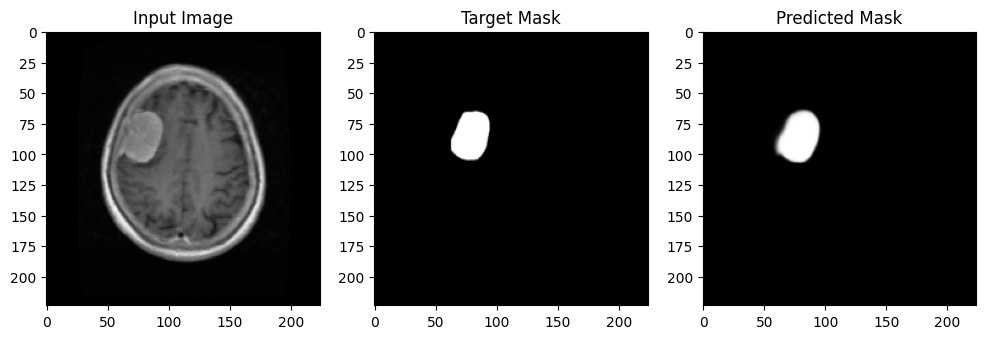

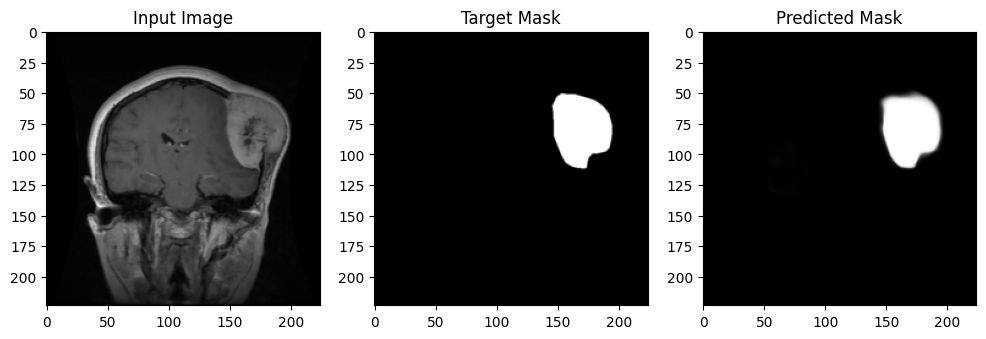

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(images, masks, outputs):
    for i in range(len(images)):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Permute to HWC

        # Target Mask
        plt.subplot(1, 3, 2)
        plt.title("Target Mask")
        plt.imshow(masks[i].squeeze(0).cpu().numpy(), cmap='gray')  # Squeeze to remove channel dimension

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(outputs[i].squeeze(0).cpu().numpy(), cmap='gray')  # Squeeze to remove channel dimension

        plt.show()

# Call the visualization function
visualize_results(images.cpu(), masks.cpu(), outputs.cpu())